In [1]:
import requests
from bs4 import BeautifulSoup
import re
from datetime import datetime
from dateutil import parser as dparser
import urllib.parse
import timeit

import numpy as np
import pandas as pd
import math
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from scipy import sparse

from transformers import DistilBertForSequenceClassification, DistilBertTokenizer
import torch
from transformers import pipeline

from util.config import config
from util.pyRanker import BM25
from util.web_query_v2 import web_query
from util.ticker import Ticker
import ipywidgets as widgets

import dash
from dash import html
from dash import dcc
import plotly.graph_objects as go
import plotly.express as px

In [2]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english')
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english')
classifier = pipeline(task='sentiment-analysis',model=model,tokenizer=tokenizer)
max_tokens = int(tokenizer.model_max_length)

In [3]:
#running through sub_docs and outputting sentiment list

def get_sentiments(docs):
    
    c = 0
    for x in docs.keys():
        c+=len(docs[x])
    
    pgres = widgets.IntProgress(value=0,min=0,max=c, step=1)
    display(pgres)
    
    sentiments = {}
    
    for x in docs.keys():
        scrs=[]
        for y in range(0, len(docs[x])):
            
            s = classifier(docs[x][y])
            scr = s[0]['score']
            if s[0]['label']=="NEGATIVE":
                scr=scr*-1
            scrs.append(scr)
            pgres.value+=1
            pgres.description=str(pgres.value)+":"+str(c)
        
        sentiments[x]=scrs
                
    return sentiments

In [4]:
class Corpus(object):
    
    #******************************************************************************
    #----------------------------------Method---------------------------------------
    #******************************************************************************
    
    #Run the web_query to produce a collection of text documents scraped from the web
    
    #Use the set_results() function to store the full results in the corpus for processing
    
    #Use the set_corpus() function to assign the documents scraped from the web to the corpus
    
    #Sub divide the documents into smaller sub_docs
    
    #Rank the documents based on relevance to the original query as well as any tags
    
    #Prune the sub_docs to produce a relevant set
    
    #
    
    #******************************************************************************
    #******************************************************************************
    
    def __init__(self):
        
        #typical corpus data
        self.documents = []
        self.vocabulary = []
        self.number_of_documents = 0
        self.vocabulary_size = 0
                
        #for web results
        self.query_results=None
        self.max_tokens=512
        self.failed = []
        
        #sub dividing documents
        self.tokenizer=None
        self.sub_docs=None
        self.sub_list=[]
        
        #queries
        self.prime_q=None
        self.expanded_q=None        
        
        #relevance scores
        self.document_scores=None
        self.subdoc_scores=None
        self.title_scores=None
        self.sub_list_scores=None
                
        #pruned data
        self.pruned_docs=[]
        self.pruned_subdocs={}
        
        #relevant
        self.relevant_set={}
        self.relevant_scores={}
        self.rel_list_scores=[]
        
        #sentiments
        self.sentiments=None
    
    
    #******************************************************************************
    #------------------------------Setting Corpus----------------------------------
    #******************************************************************************
    
    def set_results(self, df):
        #dataframe returned from webquery
        self.query_results=df
    
    def set_corpus(self, documents):
        self.documents = documents
                

    def build_corpus_from_file(self, file_path):

        f = open(file_path, 'r')
        docs = f.readlines()
        for d in docs:
            self.documents.append(d)
        self.number_of_documents = len(docs)

        
    def build_vocabulary(self, stopwords):

        v = set([])
        for x in self.documents:
            tmp = set(x.split())
            tmp = {x for x in tmp if x.lower() not in stopwords}
                        
            v.update(tmp)
        
        v = list(v)
        self.vocabulary = v
        self.vocabulary_size = len(v)
    
    
    #******************************************************************************
    #---------------------------------Queries--------------------------------------
    #******************************************************************************
    
    def set_ticker_data(self, ticker):
        name = re.sub('(Inc|Company|Corporation|Corp|Co|Incorporated|LLC|,|\.| )',"",str(ticker.name), flags=re.I)
        self.ticker_sym = str(ticker.ticker)
        self.company_name = str(name)
        self.ticker_tags = ticker.tags    
    
    def build_queries(self, ticker=None, prime='name', prime_w=1, tag_w=0.05, include_gtags=True, gtags_w=0.01, include_btags=True, btags_w=0.01):
        
        if ticker is not None:
            self.set_ticker_data(ticker)
        
        if prime=='name':
            self.prime_q = str(self.company_name)
            self.prime_type=1
        elif prime=='ticker':
            self.prime_q = str(self.ticker_sym)
            self.prime_type=2
        elif prime=='both':
            self.prime_q = str(self.company_name)+" "+str(self.ticker_sym)
        
        gtags = ['investing','analysis','analyst','upgrade','downgrade']
        btags = ['sentiment','opinion','outlook']
        
        exp = []
        for t in self.ticker_tags:
            exp.append([t, tag_w])
        if include_gtags:
            for t in gtags:
                exp.append([t, gtags_w])
        if include_btags:
            for t in btags:
                exp.append([t, btags_w])
        
        self.expanded_q=exp
    
    #******************************************************************************
    #------------------------------Sub Dividing-------------------------------------
    #******************************************************************************
    
    def get_pgraphs(self, doc, cutoff, method):
        #updated get_pgraphs() with method for cutoff
        #cut off method:
        #sen: number of sentences
        #word: number of words  

        pgraphs=[]
        freshsoup = re.split('\n\n',doc)
        for x in range(0,len(freshsoup)):
            if method=='word':
                words = len(str(freshsoup[x]).strip().split(' ',maxsplit=cutoff))
                if words>cutoff:
                    pgraphs.append(freshsoup[x])
                    
            elif method=='sen':
                sens = len(re.findall("\.",str(freshsoup[x]).strip()))
                if sens>cutoff:
                    pgraphs.append(freshsoup[x])
                    
        return pgraphs
    
    def split_doc(self, doc):         
        
        if len(doc)>0:
            avgwrds = 15
            estsens = len(doc)/avgwrds
        
            if len(re.findall('\.',doc))>=estsens:
                cut_point = doc.rfind('.', 0, int(len(doc)/2))
                if cut_point<=0:
                    cut_point = int(len(doc)/2)
            else:
                cut_point = int(len(doc)/2)

            d1 = doc[0:cut_point]
            d2 = doc[cut_point+1:]
            
            tkns1 = int(len(self.tokenizer(d1)['input_ids']))

            if tkns1>self.max_tokens:
                self.split_doc(d1)
            else:
                if len(d1)>0:
                    self.subs.append(d1)

            tkns2 = int(len(self.tokenizer(d2)['input_ids']))

            if tkns2>self.max_tokens:
                self.split_doc(d2)
            else:
                if len(d2)>0:
                    self.subs.append(d2)

    
    def get_subdocs(self, pgraphs):
        #Updated get_subdocs with iterative slicing 
        #Changed to recursive slicing
        #ensure sub_docs tokens will not exceed max_tokens for sentiment model
        self.subs=[]

        for x in range(0, len(pgraphs)):
            sen_cnt = len(re.split('\n|\. ',pgraphs[x]))
            tkns = int(len(tokenizer(pgraphs[x])['input_ids']))

            if tkns<self.max_tokens:
                self.subs.append(pgraphs[x])
            else:
                self.split_doc(pgraphs[x])
        
        return self.subs
        
    def sub_divide(self, tokenizer, cutoff=1, method='sen'):

        #creates a dictionary of sub_docs divided from each document in the corpus
        #method: using get_pgraphs() followed by get_subdocs()
        #output form: dict{ document_id : [subdoc_1, subdoc_2 ... subdoc_n] }

        subbed_data = {}
        self.tokenizer=tokenizer
        
        if len(self.pruned_docs)==0:
            self.prune_docs()
        
        for x in range(0, len(self.documents)):
            
            #only include documents that made the first relevance cut
            if x in self.pruned_docs:
                pg = self.get_pgraphs(self.documents[x], cutoff, method)
                subs = self.get_subdocs(pg)
                subbed_data[x]=subs
        
        self.sub_docs = subbed_data
        self.sub_list=[]
        for x in self.sub_docs.keys():
            for y in self.sub_docs[x]:
                self.sub_list.append(y)
        

        
    #******************************************************************************
    #----------------------------------Relevance Scoring---------------------------
    #******************************************************************************  
    
    def rank_docs(self, ranker, min_max=0.02):
        query = self.prime_q
        scr = ranker.score(query, self.documents)
        if np.max(scr)>min_max:
            self.document_scores = scr
        else:
            print('Very low relevance scores, attempting requery')
            #rebuilding queries with prime query being alternate of current prime(name or ticker)
            if self.prime_type==1:
                self.build_queries(prime='ticker')
            else:
                self.build_queries(prime='name')
        
        query = self.prime_q
        scr = ranker.score(query, self.documents)
        if np.max(scr)>min_max:
            self.document_scores = scr
        else:
            print('Scoring on built queries from ticker resulting in unusually low scores')
            print('Change query manually in rank_docs function or adjust min_max')
        
    def rank_subdocs(self, ranker, expanded=False):
        sub_vecs={}
        
        if expanded==False:
            query=self.prime_q
            for x in self.sub_docs.keys():
                sub_vec = ranker.score(query, self.sub_docs[x])
                sub_vecs[x]=sub_vec
        else:
            query = self.expanded_q
            for x in self.sub_docs.keys():
                sub_vec = ranker.score_expanded(query, self.sub_docs[x])
                sub_vecs[x]=sub_vec
            
        self.subdoc_scores = sub_vecs
        
        self.sub_list_scores=[]
        for x in self.subdoc_scores.keys():
            for y in self.subdoc_scores[x]:
                self.sub_list_scores.append(y)
    
    def rank_relevant(self, ranker, expanded=True):
        sub_vecs={}
        
        if expanded==False:
            query=self.prime_q
            for x in self.relevant_set.keys():
                sub_vec = ranker.score(query, self.relevant_set[x])
                sub_vecs[x]=sub_vec
        else:
            query=self.expanded_q
            for x in self.relevant_set.keys():
                sub_vec = ranker.score_expanded(query, self.relevant_set[x])
                sub_vecs[x]=sub_vec
            
        self.relevant_scores = sub_vecs
        
        self.rel_list_scores=[]
        for x in self.relevant_scores.keys():
            for y in self.relevant_scores[x]:
                self.rel_list_scores.append(y)
       
        
    #******************************************************************************
    #----------------------------Pruning Relevant Set------------------------------
    #******************************************************************************
    def prune_docs(self, method='finite', cutoff=0):
        
        '''
        method percentile: cutoff is the percentile to lower bound the document scores on
        method finite: cutoff is a hard value to cutoff scores on
        
        store the indexes of the documents that have scores over the cutoff
        these indexes will be used in the creation of the subdocs
        '''
        
        if method=='percentile':
            p = np.percentile(self.document_scores, cutoff)
            cuts = np.where(self.document_scores<p)
            
            for x in range(0, len(self.documents)):
                if x not in cuts:
                    self.pruned_docs.append(x)
                                                 
        elif method=='finite':
            for x in range(0, len(self.documents)):
                if self.document_scores[x]>cutoff:
                    self.pruned_docs.append(x)
        
        
            
    def prune_subdocs(self, method='finite', cutoff=0):
        
        '''
        method percentile: cutoff is the percentile to lower bound the document scores on
        method finite: cutoff is a hard value to cutoff scores on
        
        '''
        
        if method=='percentile':
            p = np.percentile(self.sub_list_scores, cutoff)
            prune={}
            for x in self.sub_docs.keys():
                for y in range(0, len(sub_docs[x])):
                    if subdoc_scores[x][y]>p:
                        if x not in prune.keys():
                            prune[x]=[y]
                        else:
                            prune[x].append(y)
            self.pruned_subdocs=prune
            
        elif method=='finite':
            prune={}
            for x in self.sub_docs.keys():
                for y in range(0, len(self.sub_docs[x])):
                    if self.subdoc_scores[x][y]>cutoff:
                        if x not in prune.keys():
                            prune[x]=[y]
                        else:
                            prune[x].append(y)
            
            self.pruned_subdocs=prune
        
    def make_relevant(self):
        for x in self.pruned_subdocs.keys():
            self.relevant_set[x]=[]
            self.relevant_scores[x]=[]
            for y in self.pruned_subdocs[x]:
                self.relevant_set[x].append(self.sub_docs[x][y])
                self.relevant_scores[x].append(self.subdoc_scores[x][y])
        
        self.rel_list=[]
        for x in self.relevant_set.keys():
            for y in self.relevant_set[x]:
                self.rel_list.append(y)
        
    def prune_relevant(self, method='percentile',cutoff=15):
        #Relevant is as low as it goes, these will be adjusted directly when pruned
        
        if method=='percentile':
            cut = np.percentile(self.rel_list_scores, cutoff)
        else:
            cut = cutoff
        
        subbed_data = self.relevant_set
        sub_scores = self.relevant_scores
        
        for x in self.relevant_set.keys():

            subbed_data[x] = [xv if c else None for c, xv in zip(sub_scores[x]>cut, subbed_data[x])]
            subbed_data[x] = [y for y in subbed_data[x] if y!=None]
            sub_scores[x] = [y for y in sub_scores[x] if y>cut]
        
        self.relevant_set = {k: v for k, v in subbed_data.items() if len(v) > 0}
        self.relevant_scores={k: v for k, v in sub_scores.items() if len(v) > 0}
        
        self.rel_list=[]
        for x in self.relevant_set.keys():
            for y in self.relevant_set[x]:
                self.rel_list.append(y)
        
 


In [5]:
fullstart = timeit.default_timer()

In [6]:
#pull api keys from the config file
cfig=config()

In [7]:
tick = Ticker(config=cfig, t="MSFT", source='alpha')

In [8]:
#Define Web_query object
wq=web_query(cfig)

In [9]:
start = timeit.default_timer()

#testq=str(tick.name)

d_start="9/1/2021"

#query all of the news apis in web_query object
#wq.query_all(query=tick.name, ticker=tick.ticker, d_start=d_start, threaded=False, pages=1)

#web_query_v2 for ticker object handling and multi-page api requests (when they work)
wq.query_all(tickerobj=tick, d_start=d_start, threaded=True, pages=4)

#compile results into a singular dataframe
wq.compile_results()

end = timeit.default_timer()
print(end-start)

Polygon: 500
NewsAPI: 100 page: 1
Usearch: 50 page: 1
Currents: 159 page: 1
error on Newsapi page: 2
Currents: 0 page: 2
Usearch: 50 page: 2
error on Newsapi page: 3
Currents: 0 page: 3
Usearch: 50 page: 3
error on Newsapi page: 4
Currents: 0 page: 4
Usearch: 50 page: 4
8.901233000000005


In [10]:
print(len(wq.results))

896


In [11]:
start = timeit.default_timer()

#scrap text from the results urls to form documents
wq.scrape_results(threaded=True, max_docs='max')

end = timeit.default_timer()
print('scrape time:',end-start)
print('time per url:', (end-start)/len(wq.results))

IntProgress(value=0, max=896)

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


scrape time: 154.53385160000002
time per url: 0.17247081651785717


In [12]:
df = wq.get_results()
print(len(df))

896


In [13]:
#build corpus from web query results
corpus=Corpus()
#store the web query data frame in the corpus for referencing urls and titles
corpus.set_results(df)
#assign corpus documents as the web query documents
corpus.set_corpus(wq.documents)

In [14]:
#pull in stop words and build corpus vocabulary 
stopwords=[]
with open('util/stopwords.txt') as f:
    stopwords.append(f.read().splitlines())
stopwords=stopwords[0]

corpus.build_vocabulary(stopwords)

print("Vocabulary size:" + str(len(corpus.vocabulary)))
print("Number of documents:" + str(len(corpus.documents)))

Vocabulary size:64338
Number of documents:784


In [15]:
bm25 = BM25(norm='l2', smooth_idf=True, stopwords=stopwords, sublinear_tf=True)
bm25.fit(corpus.documents)

In [16]:
corpus.build_queries(ticker=tick)
print('Prime query:',corpus.prime_q)
corpus.rank_docs(ranker=bm25)
corpus.prune_docs()

Prime query: Microsoft


In [17]:
#bm25.score(corpus.ticker_sym, corpus.documents)

In [18]:
start = timeit.default_timer()

#create the sub_documents, wrapper to run multiple functions
#passing in the tokenizer to save a little on class dependencies

corpus.sub_divide(tokenizer=tokenizer, cutoff=2, method='sen')
print('Sub-docs:',len(corpus.sub_list))
print('Source count:', len(corpus.sub_docs))

end = timeit.default_timer()
print(end-start)

Token indices sequence length is longer than the specified maximum sequence length for this model (1312 > 512). Running this sequence through the model will result in indexing errors


Sub-docs: 6822
Source count: 692
45.046459200000015


In [19]:
corpus.rank_subdocs(ranker=bm25)

In [20]:
corpus.prune_subdocs()

In [21]:
print("Number of sub_docs:",len(corpus.sub_list))
t = np.array(corpus.sub_list_scores)
z=np.where(t==0.0)
print("Number zero ranked:", len(z[0]))
print("percent of useless subdocs:", round((len(z[0])/len(corpus.sub_list))*100,2),"%")

Number of sub_docs: 6822
Number zero ranked: 5057
percent of useless subdocs: 74.13 %


In [22]:
corpus.make_relevant()
print('relevant sources:',len(corpus.relevant_set))
print('relevant sub_docs:',len(corpus.rel_list))

relevant sources: 676
relevant sub_docs: 1765


In [23]:
corpus.rank_relevant(ranker=bm25)

In [24]:
#corpus.prune_relevant()
print('relevant sources:',len(corpus.relevant_set))
print('relevant sub_docs:',len(corpus.rel_list))

relevant sources: 676
relevant sub_docs: 1765


In [25]:
relevant_set = corpus.relevant_set
relevant_scores = corpus.relevant_scores
print(len(relevant_set))

676


In [26]:
#run the new relevant set through distilled-BERT and get sentiment classifications
start = timeit.default_timer()

sentiments = get_sentiments(relevant_set)

end = timeit.default_timer()
print(end-start)

IntProgress(value=0, max=1765)

368.098819


In [27]:
lens=[]
for x in relevant_set.keys():
    for y in range(0, len(relevant_set[x])):
        lens.append(len(relevant_set[x][y]))

In [28]:
avlen=np.mean(lens)

In [29]:
len_weight={}
for x in relevant_set.keys():
    l=[]
    for y in range(0, len(relevant_set[x])):
        l.append(len(relevant_set[x][y])/avlen)
    len_weight[x]=l

In [30]:
adjusted_rel = {}
for x in relevant_scores.keys():
    l=[]
    for y in range(0, len(relevant_scores[x])):
        l.append(relevant_scores[x][y] * len_weight[x][y])
    adjusted_rel[x]=l

In [31]:
rel_scores={}
adj_rel_scores={}

for x in relevant_scores.keys():
    rel_scores[x]=np.mean(relevant_scores[x])
    adj_rel_scores[x]=np.mean(adjusted_rel[x])
    

In [110]:
sents={}
for x in sentiments:
    sents[x]=np.mean(sentiments[x])

In [32]:
rw_scores=[]
lrw_scores=[]
for x in relevant_scores.keys():
    for y in range(0, len(relevant_scores[x])):
        rw_scores.append(relevant_scores[x][y] * sentiments[x][y])
        lrw_scores.append(adjusted_rel[x][y] * sentiments[x][y])

In [33]:
scores={}
la_scores={}

for x in relevant_scores.keys():
    rws=0
    lrws=0
    for y in range(0, len(relevant_scores[x])):
        rws += (relevant_scores[x][y] * sentiments[x][y])
        lrws += (adjusted_rel[x][y] * sentiments[x][y])
    scores[x]=rws
    la_scores[x]=lrws

In [35]:
print("Average Relevance weighted Sentiment:", np.mean(rw_scores).round(4))
print("Average Length adjusted Relevance weighted sentiment:", np.mean(lrw_scores).round(4))


Average Relevance weighted Sentiment: -0.0884
Average Length adjusted Relevance weighted sentiment: -0.1155


In [36]:
df.head()

,title,url,pub_date
0,Should You Buy Bitcoin While It's Still Below ...,https://www.fool.com/investing/2021/12/03/shou...,2021-12-03T16:57:00Z
1,Equity Futures Holding on to Thursday’s Gains ...,https://www.investing.com/analysis/equity-futu...,2021-12-03T15:40:00Z
2,U.S. Unemployment Rate Falls Despite Low Jobs ...,https://www.benzinga.com/news/earnings/21/12/2...,2021-12-03T15:18:54Z
3,Amazon's (AMZN) 18 Projects to Bolster Net-Zer...,https://www.zacks.com/stock/news/1835028/amazo...,2021-12-03T14:16:00Z
4,Lucid and Nio Are Falling; Is the EV Stock Boo...,https://www.fool.com/investing/2021/12/03/luci...,2021-12-03T14:08:00Z


In [112]:
#need weight adjusted score per source
newdf = df
newdf['scores'] = pd.Series(scores)
newdf['sentiments'] = pd.Series(sents)
newdf['relevance'] = pd.Series(rel_scores)

In [113]:
newdf

,title,url,pub_date,sentiments,relevance,scores
0,Should You Buy Bitcoin While It's Still Below ...,https://www.fool.com/investing/2021/12/03/shou...,2021-12-03T16:57:00Z,-0.998215,0.103663,-0.103478
1,Equity Futures Holding on to Thursday’s Gains ...,https://www.investing.com/analysis/equity-futu...,2021-12-03T15:40:00Z,-0.118629,0.132345,0.393822
2,U.S. Unemployment Rate Falls Despite Low Jobs ...,https://www.benzinga.com/news/earnings/21/12/2...,2021-12-03T15:18:54Z,NaN,NaN,NaN
3,Amazon's (AMZN) 18 Projects to Bolster Net-Zer...,https://www.zacks.com/stock/news/1835028/amazo...,2021-12-03T14:16:00Z,-0.993074,0.422003,-0.839965
4,Lucid and Nio Are Falling; Is the EV Stock Boo...,https://www.fool.com/investing/2021/12/03/luci...,2021-12-03T14:08:00Z,-0.764772,0.000000,0.000000
...,...,...,...,...,...,...
45,Microsoft Co. (NASDAQ:MSFT) Shares Acquired by...,https://www.americanbankingnews.com/2021/10/11...,2021-10-11T12:42:43,0.995868,0.250879,0.249842
46,The Chart for Microsoft Corporation (MSFT) Is ...,https://newsheater.com/2021/10/11/the-chart-fo...,2021-10-11T12:24:00,-0.546201,0.176334,-0.329404
47,Lombard Odier Asset Management USA Corp Takes ...,https://www.tickerreport.com/banking-finance/7...,2021-10-11T11:12:41,-0.984302,0.266632,-0.797446
48,Roll up the Sleeves! When the bell rang at pre...,https://investchronicle.com/2021/10/11/roll-up...,2021-10-11T11:04:00,NaN,NaN,NaN


In [114]:
newdf = newdf.dropna()

In [115]:
newdf.head()

,title,url,pub_date,sentiments,relevance,scores
0,Should You Buy Bitcoin While It's Still Below ...,https://www.fool.com/investing/2021/12/03/shou...,2021-12-03T16:57:00Z,-0.998215,0.103663,-0.103478
1,Equity Futures Holding on to Thursday’s Gains ...,https://www.investing.com/analysis/equity-futu...,2021-12-03T15:40:00Z,-0.118629,0.132345,0.393822
3,Amazon's (AMZN) 18 Projects to Bolster Net-Zer...,https://www.zacks.com/stock/news/1835028/amazo...,2021-12-03T14:16:00Z,-0.993074,0.422003,-0.839965
4,Lucid and Nio Are Falling; Is the EV Stock Boo...,https://www.fool.com/investing/2021/12/03/luci...,2021-12-03T14:08:00Z,-0.764772,0.000000,0.000000
5,Amazon (AMZN) Boosts AWS Offerings With Databa...,https://www.zacks.com/stock/news/1834990/amazo...,2021-12-03T13:37:00Z,-0.929294,0.706147,-1.992133


In [116]:
#pd.to_datetime(newdf['pub_date'], format='%Y-%m-%dT%H:%M:%S')
newdf.loc[:,'pub_date'] = pd.to_datetime(newdf.loc[:,'pub_date'], infer_datetime_format=True, utc=True)
newdf.loc[:,'pub_date'] = pd.to_datetime(newdf.loc[:,'pub_date'].dt.strftime('%Y/%m/%d'))


C:\Users\Tony\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [117]:
newdf.head()

,title,url,pub_date,sentiments,relevance,scores
0,Should You Buy Bitcoin While It's Still Below ...,https://www.fool.com/investing/2021/12/03/shou...,2021-12-03,-0.998215,0.103663,-0.103478
1,Equity Futures Holding on to Thursday’s Gains ...,https://www.investing.com/analysis/equity-futu...,2021-12-03,-0.118629,0.132345,0.393822
3,Amazon's (AMZN) 18 Projects to Bolster Net-Zer...,https://www.zacks.com/stock/news/1835028/amazo...,2021-12-03,-0.993074,0.422003,-0.839965
4,Lucid and Nio Are Falling; Is the EV Stock Boo...,https://www.fool.com/investing/2021/12/03/luci...,2021-12-03,-0.764772,0.000000,0.000000
5,Amazon (AMZN) Boosts AWS Offerings With Databa...,https://www.zacks.com/stock/news/1834990/amazo...,2021-12-03,-0.929294,0.706147,-1.992133


In [118]:
plotdf = newdf[['pub_date','sentiments','relevance','scores']]
plotdf.head()

,pub_date,sentiments,relevance,scores
0,2021-12-03,-0.998215,0.103663,-0.103478
1,2021-12-03,-0.118629,0.132345,0.393822
3,2021-12-03,-0.993074,0.422003,-0.839965
4,2021-12-03,-0.764772,0.000000,0.000000
5,2021-12-03,-0.929294,0.706147,-1.992133


In [119]:
print(np.min(plotdf['pub_date']))
print(np.max(plotdf['pub_date']))

2021-09-01 00:00:00
2021-12-03 00:00:00


In [120]:
pt_sn = plotdf.groupby(plotdf['pub_date'])['sentiments'].mean()
pt_rl = plotdf.groupby(plotdf['pub_date'])['relevance'].mean()
pt_sc = plotdf.groupby(plotdf['pub_date'])['scores'].mean()
pt_dt = pd.DataFrame()
pt_dt = plotdf['sentiments'].groupby(plotdf['pub_date']).count()

In [121]:
pt_sn = pt_sn.to_frame()
pt_rl = pt_rl.to_frame()
pt_sc = pt_sc.to_frame()
pt_dt = pt_dt.to_frame().rename(columns={"sentiments":"Volume"})

In [129]:
dff = pd.concat([pt_rl, pt_sn, pt_sc, pt_dt], axis=1)


In [130]:
dff = dff.reset_index()
dff = dff.drop([0,1])
dff = dff.set_index('pub_date')


In [99]:
drange='1mo'
interval='1d'

yheaders = {'x-api-key':cfig.yahoo}
url = ('https://yfapi.net/v8/finance/spark?'
        'interval='+interval+
        '&range='+drange+
        '&symbols='+tick.ticker)

response = requests.request("GET",url,headers=yheaders)
if response.status_code==200:
        response = response.json()



In [100]:
date = response[tick.ticker]['timestamp']
price = response[tick.ticker]['close']
df2 = pd.DataFrame()
df2['date']=date
df2.loc[:,'date'] = pd.to_datetime(df2.loc[:,'date'], unit='s')
df2.loc[:,'date'] = pd.to_datetime(df2.loc[:,'date'].dt.strftime('%Y/%m/%d'))
df2['price']=price
df2 = df2.set_index('date')


In [132]:
tmp = dff[dff.columns[0:3]]
tmp.head()

,relevance,sentiments,scores
pub_date,,,
2021-09-07,0.495515,0.979433,0.538857
2021-09-08,0.778927,-0.008359,-0.215659
2021-09-09,0.000000,-0.271194,0.000000
2021-09-13,0.285944,0.003346,0.079550
2021-09-14,0.536147,0.003812,0.351092


<AxesSubplot:xlabel='pub_date'>

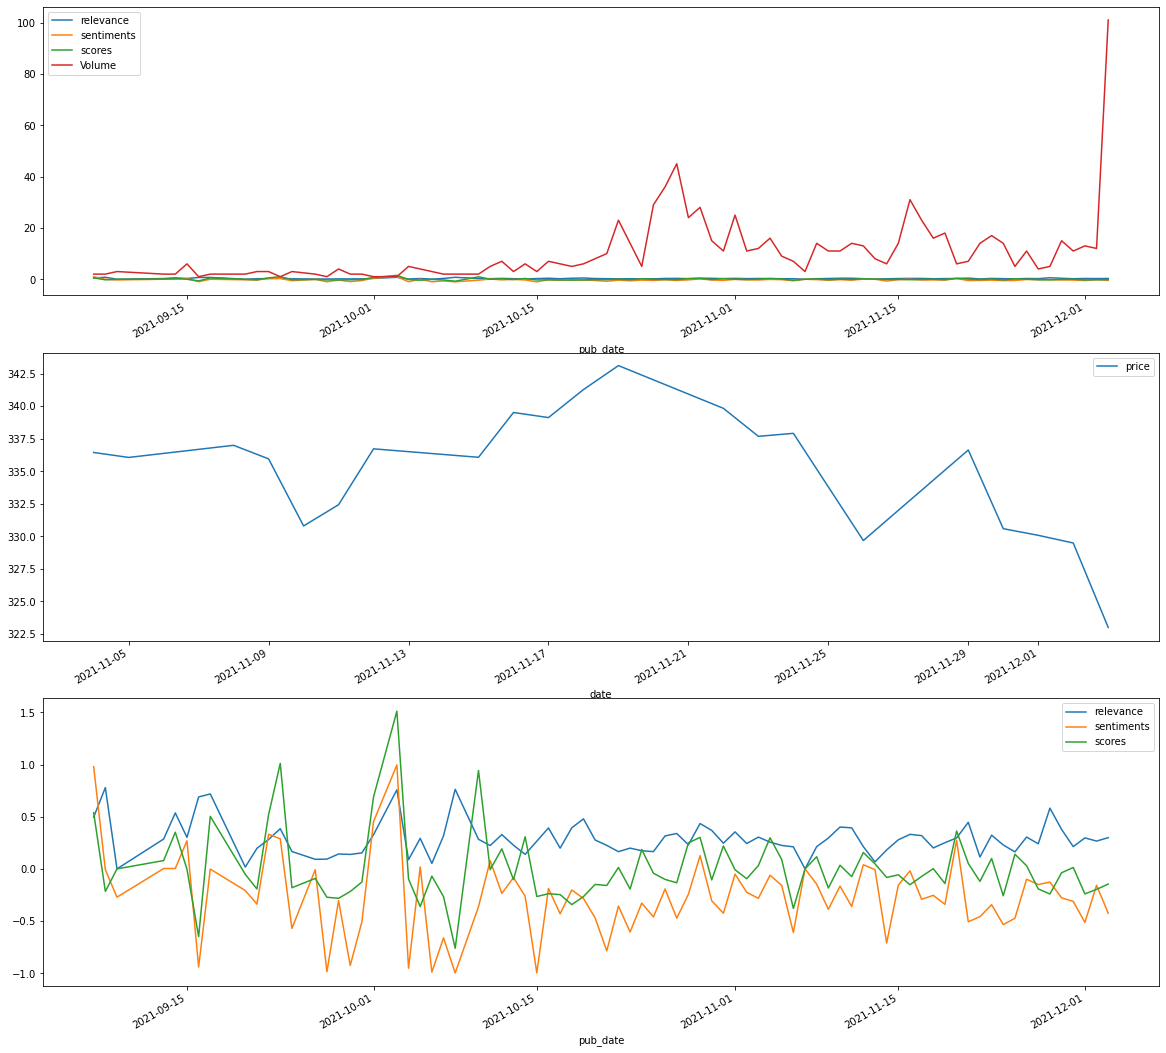

In [133]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=3)

dff.plot(ax=axes[0], figsize=(20,20))
df2.plot(ax=axes[1], figsize=(20,20))
tmp.plot(ax=axes[2], figsize=(20,20))

In [58]:
drange='6mo'
interval='1d'


url=('https://yfapi.net/v8/finance/chart/'+tick.ticker+"?"+
    'comparisons='+tick.ticker+
    '&range='+drange+
    '&region=US'
    '&interval='+interval+
    '&lang=en')
response = requests.request("GET",url,headers=yheaders)
if response.status_code==200:
        response = response.json()            

In [59]:
date = response['chart']['result'][0]['timestamp']
volume = response['chart']['result'][0]['indicators']['quote'][0]['volume']
high = response['chart']['result'][0]['indicators']['quote'][0]['high']
low = response['chart']['result'][0]['indicators']['quote'][0]['low']
opn = response['chart']['result'][0]['indicators']['quote'][0]['open']
cls = response['chart']['result'][0]['indicators']['quote'][0]['close']

In [60]:
df3 = pd.DataFrame()
df3['date']=date
df3['high']=high
df3['low']=low
df3['open']=opn
df3['close']=cls
df3['volume']=volume
df3.loc[:,'date'] = pd.to_datetime(df3.loc[:,'date'], unit='s')
df3.loc[:,'date'] = pd.to_datetime(df3.loc[:,'date'].dt.strftime('%Y/%m/%d'))

In [135]:
dff=dff.reset_index()

In [136]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=3, cols=1, shared_xaxes=True,vertical_spacing=0.02, subplot_titles=(tick.ticker,'Sentiment_Score', 'Used News Volume'), 
               row_width=[0.4, 0.4, 1.5], specs=[[{"secondary_y": True}],[{"secondary_y": True}],[{"secondary_y": True}]])
fig.add_trace(go.Candlestick(x=df3['date'],
                open=df3['open'], high=df3['high'],
                low=df3['low'], close=df3['close'], name="Price"),
               secondary_y=True, row=1,col=1)

fig.add_trace(go.Bar(x=df3['date'], y=df3['volume'],opacity=0.2, name='Volume'),secondary_y=False)
fig.add_trace(go.Line(x=dff['pub_date'], y=dff['scores'], showlegend=False), row=2, col=1)
fig.add_trace(go.Bar(x=dff['pub_date'],y=dff['Volume'],opacity=0.2, name='Used News Volume'),row=3, col=1)
fig.update_layout(xaxis_rangeslider_visible=False, width=1000, height=750)
fig.layout.yaxis2.showgrid=False
fig.show()

C:\Users\Tony\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




In [57]:
fullstop = timeit.default_timer()


Full compile, sub-divide, analyze and graph time: 603.2418914


In [68]:
print('Tiny Report')
print('Full compile, sub-divide, analyze and graph time:', round((fullstop-fullstart)/60,2), "minutes")
print('Urls scraped:', len(corpus.documents))
print('Relevant Subdocs created:', len(corpus.rel_list))

Tiny Report
Full compile, sub-divide, analyze and graph time: 10.05 minutes
Urls scraped: 784
Relevant Subdocs created: 1765
